# Week 07. Classification metric

## 0. Load data

In [1]:
import numpy as np
import pandas as pds
import os

import matplotlib as MP
from matplotlib import pyplot as plt
import seaborn as sbn

data = pds.read_csv(
    '../files/week06/Week 06. data-wine-red.csv',
    delimiter=';'
)

print(data.quality.value_counts())
data.quality -= 3

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64


## 1. Train & predict to $k$-NN 

In [2]:
from itertools import product
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

from sklearn.neighbors import KNeighborsClassifier as KNC

def ss_kfold_fn(data, scaling = True):
    kf = StratifiedKFold()
    for n, (train_idx, valid_idx) in enumerate(kf.split(data, data.quality)):
        
        scaler_x = StandardScaler()
        
        if scaling:
            train_x = scaler_x.fit_transform(data.iloc[train_idx].drop(columns = 'quality'))
            valid_x = scaler_x.transform(data.iloc[valid_idx].drop(columns = 'quality'))
            
        else:
            train_x = data.iloc[train_idx].drop(columns = 'quality').values
            valid_x = data.iloc[valid_idx].drop(columns = 'quality').values

        train_y = data.iloc[train_idx]['quality'].values.reshape(-1,1)
        valid_y = data.iloc[valid_idx]['quality'].values.reshape(-1,1)
        
        yield [
            [train_x, train_y],
            [valid_x, valid_y]
        ], (scaler_x)


In [3]:
model = KNC( n_neighbors = 5, weights = 'distance' )

scalers = []
valid_y_hat = []
valid_y = []
for (train_set, valid_set), scaler in ss_kfold_fn(data, True):
    scalers.append(scaler)
    model.fit(train_set[0], train_set[1].ravel())
    valid_y.append(valid_set[1].squeeze())
    valid_y_hat.append(model.predict_proba(valid_set[0]).squeeze())
    


## 2. Confusion matrix with other metrics

<img src = https://imgur.com/LoB931f.png>

In [4]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report

In [5]:
for yt, yp in zip(valid_y, valid_y_hat):
    print(classification_report(yt, yp.argmax(1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        11
           2       0.54      0.66      0.60       137
           3       0.44      0.46      0.45       127
           4       0.47      0.20      0.28        40
           5       0.00      0.00      0.00         3

    accuracy                           0.49       320
   macro avg       0.24      0.22      0.22       320
weighted avg       0.47      0.49      0.47       320

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        10
           2       0.60      0.54      0.57       136
           3       0.47      0.58      0.52       128
           4       0.45      0.42      0.44        40
           5       1.00      0.25      0.40         4

    accuracy                           0.52       320
   macro avg       0.42

C:\Users\keb20\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\keb20\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\keb20\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C

Fold: 0 precision: 0.4651 recall: 0.4906
Fold: 1 precision: 0.5115 recall: 0.5188
Fold: 2 precision: 0.5217 recall: 0.5250
Fold: 3 precision: 0.5034 recall: 0.4875
Fold: 4 precision: 0.5069 recall: 0.5078


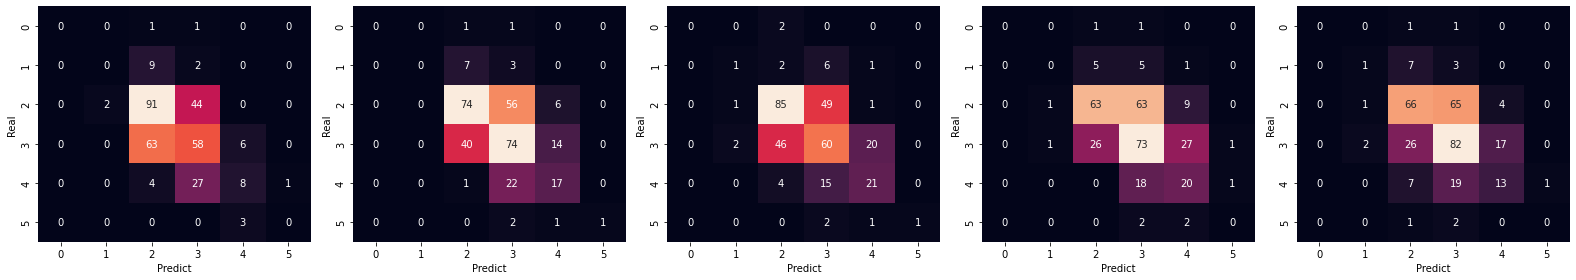

In [6]:
from matplotlib import pyplot as plt
import seaborn as sbn
import warnings

warnings.filterwarnings('ignore')

fig, ax = plt.subplots(1,5,figsize = (22, 4))
for n, (yt, yp) in enumerate(zip(valid_y, valid_y_hat)):
    conf = confusion_matrix(yt, yp.argmax(1))
    sbn.heatmap(conf, ax = ax[n], annot = conf, fmt='.4g', cbar = False)
    ax[n].set_ylabel('Real')
    ax[n].set_xlabel('Predict')
    
    P = precision_score(yt, yp.argmax(1), average='weighted')
    R = recall_score(yt, yp.argmax(1), average='weighted')
    print('Fold: {} precision: {:.4f} recall: {:.4f}'.format(n,P,R))
    
fig.tight_layout()

## 3. ROC curve & AUC

<img src = https://imgur.com/oEoVg5U.png>

<img src = https://imgur.com/euBLBb9.png>

In [7]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

def plot_roc_curve(yt, yp, ax):
    for c in range(6):
        class_yp = yp[:,c]
        fpr, tpr, thr = roc_curve(yt, class_yp, pos_label = c)
        ax.plot(fpr, tpr)
    ax.legend(['Class '+str(i) for i in range(6)])
    ax.set_title('ROC AUC: {:.4f}'.format(roc_auc_score(yt, yp, average = 'macro', multi_class = 'ovr')))

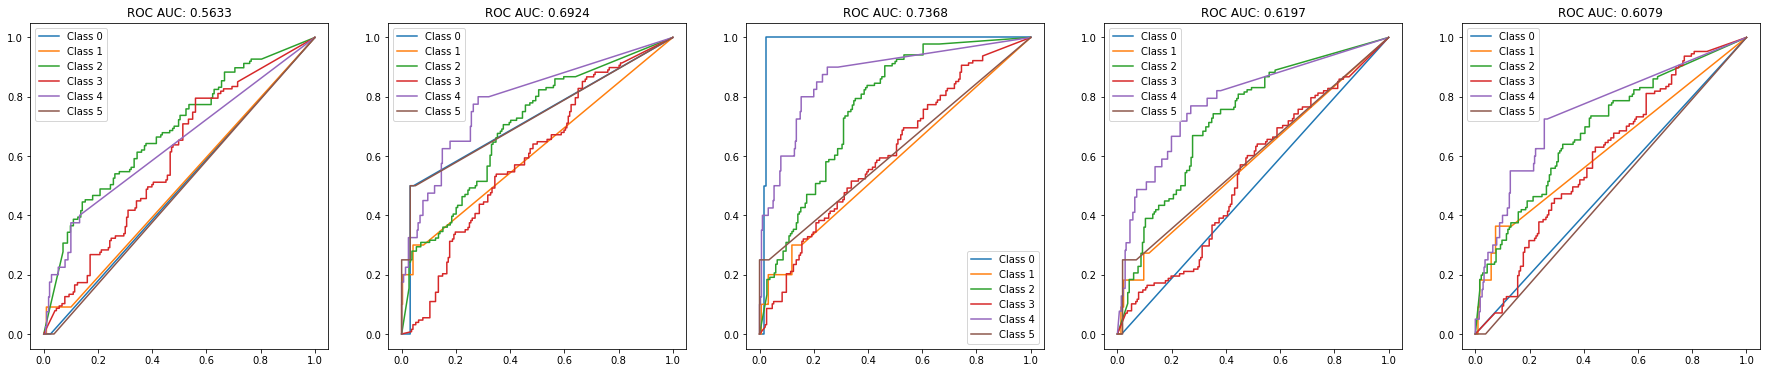

In [8]:
fig, ax = plt.subplots(1,5,figsize = (31,6))

for n, (yt, yp) in enumerate(zip(valid_y, valid_y_hat)):
    plot_roc_curve(yt, yp, ax[n])

## 4. 과제

4-1. $k$-NN의 이웃 갯수 $k$를 바꿔가며 성능을 평가해주세요.

4-2. 주어진 데이터의 예측해야 할 목표 'quality'는 regression의 관점으로 접근해 볼 수 있습니다.  
Quality를 ridge 또는 lasso로 회귀해보고 회귀 평가 지표를 활용하여 regularization term $\lambda$의 변화에 따른 모델의 성능을 평가해주세요.